# Visual Sentiment by image caption

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import (
    DataLoader,
    RandomSampler,
    TensorDataset,
    SequentialSampler,
)
from torch import optim
from torch.nn import functional as F
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)

from typing import Any, Dict, List, Tuple

from tqdm import tqdm

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, classification_report, confusion_matrix

import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [2]:
"""Settings"""

BATCH_SIZE = 32

BERT_MODEL = "DeepPavlov/rubert-base-cased"

BERT_OUTPUT = 3

MAX_SEQ_LENGTH = 128

AVAILABLE_GPU = True

IMAGE_PARENT_PATH = ".."

In [3]:
if torch.cuda.is_available() and AVAILABLE_GPU:
    device = torch.device("cuda")
    print(f"Available GPU devices: {torch.cuda.device_count()}")
    print(f"Used GPU device: {torch.cuda.get_device_name()}")
    print(torch.cuda.memory_summary())

else:
    print("There are no GPU available")
    device = torch.device("cpu")

device

Available GPU devices: 1
Used GPU device: NVIDIA GeForce RTX 3070 Ti
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 

device(type='cuda')

In [4]:
torch.cuda.empty_cache()

In [5]:
bert_feature_extractor = BertTokenizer.from_pretrained(BERT_MODEL)

In [6]:
def transform_sentences(sentences: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
    """Transform sentences to vectors."""
    input_ids = []
    attention_masks = []
    for sentence in tqdm(sentences):
        encoded_dict = bert_feature_extractor.encode_plus(
            sentence,
            add_special_tokens=True,
            truncation=True,
            max_length=MAX_SEQ_LENGTH,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids.append(encoded_dict.get("input_ids"))
        attention_masks.append(encoded_dict.get("attention_mask"))

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

In [7]:
image_info_df = pd.read_csv("../image_sentiment_data_with_captions.csv")
image_info_df.head()

,image_path,sentiment,caption,clean_caption
0,data/preprocess_images/positive/104505632.jpg,positive,"Женщина разговаривает по мобильному телефону, ...",женщина разговаривать мобильный телефон держат...
1,data/preprocess_images/positive/1059249846.jpg,positive,Женщина сидит на скамейке в парке с зонтиком.,женщина сидеть скамейка парк зонтик
2,data/preprocess_images/positive/108501238.jpg,positive,Женщина в очках и с длинными волосами держит м...,женщина очки длинный волос держать мобильный т...
3,data/preprocess_images/positive/1089046474.jpg,positive,Вид на город с высоты птичьего полета.,вид город высота птичий полет
4,data/preprocess_images/positive/1096822187.jpg,positive,Мужчина и женщина позируют фотографу.,мужчина женщина позировать фотограф


In [8]:
label_encoder = LabelEncoder()
image_info_df["label"] = label_encoder.fit_transform(image_info_df["sentiment"])
image_info_df.head()

,image_path,sentiment,caption,clean_caption,label
0,data/preprocess_images/positive/104505632.jpg,positive,"Женщина разговаривает по мобильному телефону, ...",женщина разговаривать мобильный телефон держат...,2
1,data/preprocess_images/positive/1059249846.jpg,positive,Женщина сидит на скамейке в парке с зонтиком.,женщина сидеть скамейка парк зонтик,2
2,data/preprocess_images/positive/108501238.jpg,positive,Женщина в очках и с длинными волосами держит м...,женщина очки длинный волос держать мобильный т...,2
3,data/preprocess_images/positive/1089046474.jpg,positive,Вид на город с высоты птичьего полета.,вид город высота птичий полет,2
4,data/preprocess_images/positive/1096822187.jpg,positive,Мужчина и женщина позируют фотографу.,мужчина женщина позировать фотограф,2


In [9]:
train_image_info_df, test_image_info_df = train_test_split(image_info_df, test_size=0.2)
train_image_info_df, valid_image_info_df = train_test_split(train_image_info_df, test_size=0.2)

In [10]:
train_input_ids, train_attention_masks = transform_sentences(train_image_info_df["clean_caption"].to_list())
train_labels = F.one_hot(torch.tensor(train_image_info_df["label"].to_list()).to(torch.int64)).to(torch.float64)

100%|██████████| 2083/2083 [00:00<00:00, 3118.28it/s]


In [11]:
valid_input_ids, valid_attention_masks = transform_sentences(valid_image_info_df["clean_caption"].to_list())
valid_labels = F.one_hot(torch.tensor(valid_image_info_df["label"].to_list()).to(torch.int64)).to(torch.float64)

100%|██████████| 521/521 [00:00<00:00, 3196.13it/s]


In [12]:
test_input_ids, test_attention_masks = transform_sentences(test_image_info_df["clean_caption"].to_list())
test_labels = F.one_hot(torch.tensor(test_image_info_df["label"].to_list()).to(torch.int64)).to(torch.float64)

100%|██████████| 651/651 [00:00<00:00, 3160.17it/s]


In [13]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
valid_dataset = TensorDataset(valid_input_ids, valid_attention_masks, valid_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [14]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=RandomSampler(train_dataset),
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    sampler=SequentialSampler(valid_dataset),
)
test_dataloader = DataLoader(test_dataset)

In [15]:
def f1_weighted_score(preds: torch.Tensor, labels: torch.Tensor):
    pred_numpy = preds.cpu().detach().numpy()
    labels_numpy = labels.cpu().detach().numpy()
    pred_flatten = np.argmax(pred_numpy, axis=1).flatten()
    labels_flatten = np.argmax(labels_numpy, axis=1).flatten()
    return f1_score(labels_flatten.astype(np.int32), pred_flatten.astype(np.int32), average="weighted")

In [16]:
NUM_CLASSES = len(label_encoder.classes_)

In [17]:
language_model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL,
    num_labels=BERT_OUTPUT,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

In [18]:
language_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [19]:
LEARNING_RATE = 2e-5
NUM_EPOCHS = 10
EPS = 1e-7

NUM_WARMUP_STEPS = 0
NUM_TRAINING_STEPS = len(train_dataloader) * NUM_EPOCHS

In [20]:
optimizer = optim.RMSprop(language_model.parameters(recurse=True), lr=LEARNING_RATE, eps=EPS)
loss_function = torch.nn.CrossEntropyLoss().to(device)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=NUM_TRAINING_STEPS,
)

In [21]:
import matplotlib.pyplot as plt


def plot_history(history: dict) -> None:
    train = history.get("train")
    valid = history.get("valid")
    plt.title("Loss")
    plt.plot(train.get("loss"), label="train")
    plt.plot(valid.get("loss"), label="valid")
    plt.legend()
    plt.show()
    plt.title("Accuracy")
    plt.plot(train.get("accuracy"), label="train")
    plt.plot(valid.get("accuracy"), label="valid")
    plt.legend()
    plt.show()

In [22]:
def train(
        model: torch.nn.Module,
        dataloader: DataLoader,
        optim: optim.Optimizer,
        loss_func: torch.nn.Module,
        warmup_scheduler=scheduler,
) -> Tuple[float, float]:
    loss = 0
    accuracy = 0
    model.train()
    for input_ids, attention_mask, sentiment in dataloader:
        optim.zero_grad()

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        sentiment = sentiment.to(device)

        preds_result = model(
            input_ids,
            token_type_ids=None,
            attention_mask=attention_mask,
            labels=sentiment,
        )

        logits = preds_result["logits"]

        loss_current = loss_func(logits.to(device), sentiment)

        accuracy_curr = f1_weighted_score(logits, sentiment)

        loss_current.backward()
        optim.step()
        warmup_scheduler.step()

        loss += loss_current.item()
        accuracy += accuracy_curr.item()
    return loss / len(dataloader), accuracy / len(dataloader)

In [23]:
def validate(
        model: torch.nn.Module,
        dataloader: DataLoader,
        loss_func: torch.nn.Module,
) -> Tuple[float, float]:
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for input_ids, attention_mask, sentiment in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            sentiment = sentiment.to(device)

            preds_result = model(
                input_ids,
                token_type_ids=None,
                attention_mask=attention_mask,
                labels=sentiment,
            )

            logits = preds_result["logits"]

            loss_current = loss_func(logits.to(device), sentiment)

            accuracy_current = f1_weighted_score(logits, sentiment)

            loss += loss_current.item()
            accuracy += accuracy_current.item()
    return loss / len(dataloader), accuracy / len(dataloader)

In [24]:
def training(
        model: torch.nn.Module,
        train_data: DataLoader,
        validate_data: DataLoader,
        optim: optim.Optimizer,
        loss_func: torch.nn.Module,
        num_epochs: int = 10,
) -> Dict[str, Any]:
    best_loss = float('inf')
    history = {
        "train": {
            "loss": [],
            "accuracy": [],
        },
        "valid": {
            "loss": [],
            "accuracy": [],
        }
    }
    for epoch in range(num_epochs):
        print(f"{'=' * 15} Epoch: {epoch + 1} {'=' * 15}")
        time_start = time.time()
        train_loss, train_accuracy = train(model, train_data, optim, loss_func)
        print(f"Train: loss={train_loss:.3f}, accuracy={train_accuracy:.3f}")
        validation_loss, validation_accuracy = validate(model, validate_data, loss_func)
        print(f"Validation: loss={validation_loss:.3f}, accuracy={validation_accuracy:.3f}")
        time_end = time.time()
        time_delta = time_end - time_start
        if validation_loss < best_loss:
            best_loss = validation_loss
        history["train"]["accuracy"].append(train_accuracy)
        history["train"]["loss"].append(train_loss)
        history["valid"]["accuracy"].append(validation_accuracy)
        history["valid"]["loss"].append(validation_loss)
        print(f"Time elapsed: {time_delta:.2f} s\n{'=' * 40}")
    return history

In [25]:
language_model_history = training(
    language_model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_function,
    num_epochs=NUM_EPOCHS,
)

=============== Epoch: 1 ===============
Train: loss=1.052, accuracy=0.332
Validation: loss=1.063, accuracy=0.376
Time elapsed: 39.39 s
=============== Epoch: 2 ===============
Train: loss=1.050, accuracy=0.338
Validation: loss=1.047, accuracy=0.433
Time elapsed: 25.32 s
=============== Epoch: 3 ===============
Train: loss=1.047, accuracy=0.305
Validation: loss=1.067, accuracy=0.376
Time elapsed: 25.44 s
=============== Epoch: 4 ===============
Train: loss=1.049, accuracy=0.327
Validation: loss=1.056, accuracy=0.376
Time elapsed: 25.38 s
=============== Epoch: 5 ===============
Train: loss=1.047, accuracy=0.332
Validation: loss=1.061, accuracy=0.386
Time elapsed: 28.55 s
=============== Epoch: 6 ===============
Train: loss=0.988, accuracy=0.469
Validation: loss=0.940, accuracy=0.559
Time elapsed: 28.10 s
=============== Epoch: 7 ===============
Train: loss=0.933, accuracy=0.518
Validation: loss=0.901, accuracy=0.591
Time elapsed: 27.44 s
=============== Epoch: 8 ===============
Train: 

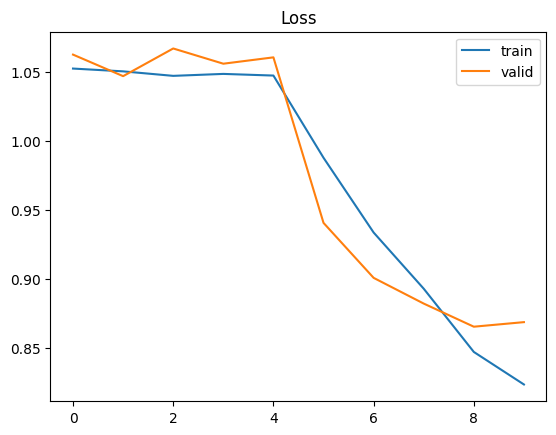

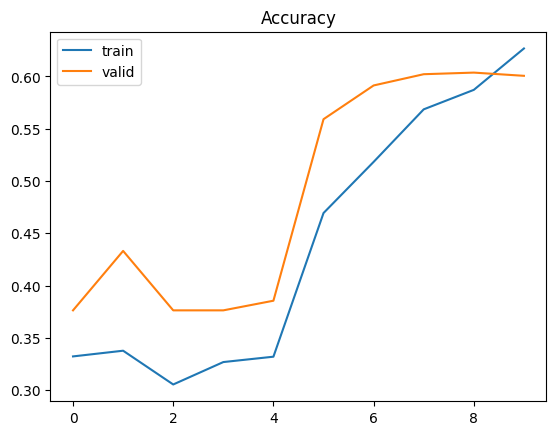

In [26]:
plot_history(language_model_history)

In [27]:
def get_predictions(model: torch.nn.Module, dataloader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, sentiment in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            preds = model(input_ids, attention_mask).logits

            preds = preds.cpu().detach().numpy()
            sentiment = sentiment.cpu().detach().numpy()

            preds = np.argmax(preds, axis=1).flatten().tolist()
            sentiment = np.argmax(sentiment, axis=1).flatten().tolist()

            predictions.extend(preds)
            true_labels.extend(sentiment)

    return np.array(predictions), np.array(true_labels)

In [28]:
y_pred, y_true = get_predictions(language_model, test_dataloader)

In [29]:
def get_classification_report(y_true, y_pred, labels):
    print(classification_report(y_true, y_pred, target_names=labels))
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred, normalize="true"), display_labels=labels).plot()

              precision    recall  f1-score   support

    negative       0.57      0.70      0.63       245
     neutral       0.35      0.15      0.21       124
    positive       0.67      0.71      0.69       282

    accuracy                           0.60       651
   macro avg       0.53      0.52      0.51       651
weighted avg       0.57      0.60      0.58       651



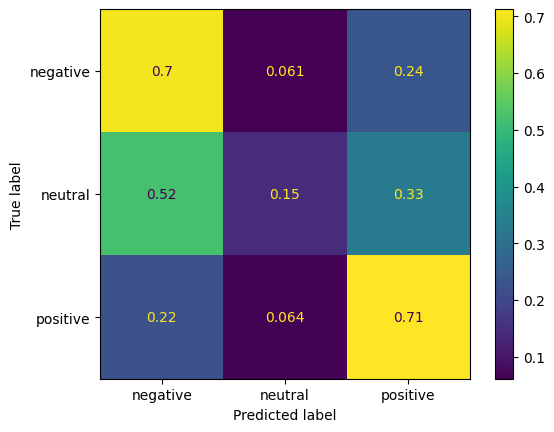

In [30]:
get_classification_report(y_true, y_pred, label_encoder.classes_)